# Addition and adaptation of Myriam's `Feature_selection_for_BRCA.pynb` 
State of the art review and additional Feature selection and visualization methods computation
(by Anaïs)

## State of the art of feature selection methods
### Relevant papers selection
- [Feature Selection: A Review and Comparative Study - 2022](https://www.e3s-conferences.org/articles/e3sconf/pdf/2022/18/e3sconf_icies2022_01046.pdf)
- [A review of feature selection methods with applications - 2015](https://bib.irb.hr/datoteka/763354.MIPRO_2015_JovicBrkicBogunovic.pdf)
- [Feature Selection for Classification: A Review - 2014](https://www.cse.msu.edu/~tangjili/publication/feature_selection_for_classification.pdf)
- [Feature Selection: A Review and Comparative Study - 2022](https://www.e3s-conferences.org/articles/e3sconf/pdf/2022/18/e3sconf_icies2022_01046.pdf)
- [Feature selection methods and genomic big data: a systematic review - 2019](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0241-0) 
- [A Review of Feature Selection Methods for Machine Learning-Based Disease Risk Prediction - 2022](https://www.frontiersin.org/articles/10.3389/fbinf.2022.927312/full)</br> This one also present a nice discussion (we can take inspiration from) on removing redundancy but keeping interesting correlated features (see paragraph: "The Problem of Feature Redundancy and Feature Interaction in SNP Genotype Dataset").

- & Additional ressource (*Myriam*): [Sklearn methods description](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

They provide consistant useful information and summary with advantages, drawbacks and examples of each methods.




### In brief 
*Info from the selection, you can look at each specific paper for more pro/cons and examples of each method*

Relevant mention before focusing on main methods:</br>
"**Dimensionality reduction** is one of the most popular techniques to remove noisy (i.e. irrelevant) and redundant features. Dimensionality reduction techniques can be categorized mainly into feature extraction and feature selection."</br>
*Examples:* PCA with features contribution score to the first PC, Variance threshold</br>
*Examples genomic work:* Sorting genome

Main strategies to get more discriminative features (for classification/regression):</br>
**3 major method types:**
- **filters** (preprocessing - independant from classifier )
    - *Pro:* fast, scalable, generalizable (more than wrapper), reduce overfitting risk
    - *Con:* not efficient, feature dependencies not modeled (univariate) 
    - *Examples:* 
        - Univariate: Chi-squared test, Fisher's exact test, Pearson correlation, information gain, t-test, Mann-Whitney U test, mutual information
        - Multivariate: Fast correlation-based filter, relief-based algorithms
    - *Examples genomic work:* mRMR, PFBP 

- **Wrappers** (predictive model trained along the selection - include classification performance of the used classifier, such as accuracy, within the evaluation of the feature selection)
    - *Pro:* efficient, take into account interactions between features, identify feature interactions of higher order, better performance than filters, model interaction with classifier
    - *Con:* computationally  expensive (even worse for big dataset) in terms of models complexity and resources requirements, slower than filters and embedded methods, more prone to overfiting, selected features classifier dependent (bias toward modelling algorithm)
    - *Examples:*  Support Vector Machine Recursive Feature Elimination SVM-RFE, Sequential Forward Selection SFS, Sequential forward and backward selection, randomized hill climbing, recursive feature elimination
    - *Examples genomic work:* MINT, Boruta random forrest, MIMIC FS, FIFS

- **Embedded** (do not separate the learning from the feature selection part, conducted and optimized during the classification process)
    - *Pro:* advantages of filters and wrappers= fast and efficient (classify dependencies with less computing difficulty than wrapper), accurate, take into account interaction between features, model feature dependencies, model interaction with classifier
    - *Con:* slower than filter, selected features classifier dependent, learning algorithm specific
    - *Examples:* SVM, LASSO (L1-Regularization) or elastic net regression, Bridge regularization, RIDGE (L2-Regularization), random forest
    - *Examples genomic work:* Random forest Naïve Bayes, Cox-regression (TCGA), mRMR IFS, ROSEFW-RF 

- **Other**: 
	- **hybrid** = multiple consecutive FS methods
	- **ensemble** = aggregate of feature subsets of diverse base classifiers
	- **integrative** = use of external knowledge

**Remarks:**</br>
- *Feature Selection for Classification: A Review* specify that the filter/wrappers/embedded methods work for **flat features** where features are assumed independent. (but, keep in mind that some papers mention the methods can detect features dependencies). We need different methods for structured features like graph (or group or set). It can be used as a **pro for our paper method that works for both flat and graph-structured features**.

- **Sklearn** Recursive feature elimination and Feature selection using SelectFromModel methods seems to be wrappers and embedded methods, difficult to distinguish which is which</br>

## Methods to implement for the paper
- Try the sklearn algorithms quick to implement

- Ideally test at least one dimension reduction, one filter, one wrapper, one embedded
    - One dim reduction method standard: PCA with contribution first PC
    - Filter: Chi-squared test - Fisher test - Pearson correlation - Mutual information
    - Wrapper: ? -- more specific, need development of a model to test subset of features while training -- Maybe SVM can be counted as wrapper too, sklearn methods difficult to distinguish between wrapper and embedded
    - Embedded: Random forest - Lasso 



## Feature selection implementation

### Librairies

In [1]:
import os
import sys
code_path = os.path.split(os.path.split(os.getcwd())[0])[0]
sys.path.append(code_path)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif, mutual_info_classif, chi2, VarianceThreshold, RFE
from sklearn.metrics import jaccard_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from setting import *
from utils import *
from loader import *

set_pyplot()

### Path

In [2]:
name = 'BRCA'  
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)

### Useful functions
[sklearn functions description](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

#### Dimension reduction
1. Variance threshold
2. PCA

In [3]:
# Univariate feature selection
## Without labels
def select_features_with_high_variance(X, threshold):
    """
    Select all features whose variance is higher some threshold.
    """
    alg = VarianceThreshold(threshold=threshold)
    alg.fit(X)
    return alg.variances_

In [4]:
# PCA
def select_features_with_PCA(X, n_PC):
    """
    Perform PCA
    Print the explained variance of the first n_PC principal components
    Return the scores of the features for the first 3 principal components
    """
    pca = PCA(n_components=n_PC)
    out = pca.fit_transform(X)

    print(f"Number of principal components: {pca.components_.shape[0]}.")
    print(f"Explained variance of the first principal components:\n {pca.explained_variance_ratio_}.")
    
    return pca.components_[0,:], pca.components_[1,:], pca.components_[2,:]


#### Filters
1. Fisher test
2. Mutual information
3. Chi-squared test 
4. Pearson correlation --> No, cf. used for regression and not classification

In [5]:
# Univariate feature selection
## With labels
def select_features_with_F_test(X, y):
    scores, p = f_classif(X, y)
    return scores

def select_features_with_mutual_information(X, y): 
    return mutual_info_classif(X, y)

def select_features_with_chi2_test(X, y):
    scores, p = chi2(X, y)
    return scores

#### Wrappers / embedded
1. Recursive feature elimination RFE - Not great, maybe not keep it see comments in code
2. L1-based 
3. Tree-based


In [6]:
# RFE - Useless
def select_features_with_RFE(X, y):
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=1.0, step=1)
    rfe.fit(X, y)
    return rfe.ranking_

# Useless, all scores equal to 1 for all features !!! Make sense since all features kept
# (Selected (i.e., estimated best) features are assigned rank 1)

# -----------------------------------------------------------------------------------------------

# RFE - Useless
def select_features_with_RFE(X, y):
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=1.0)
    rfe.fit(X, y)
    return rfe.ranking_

# Useless, all scores equal to 1 for all features !!! Make sense since all features kept 1.0 (= 100% features to keep)
# (Selected (i.e., estimated best) features are assigned rank 1)

# -----------------------------------------------------------------------------------------------

# RFE - More useful but reaaaaaally Longer to compute
def select_features_with_RFE(X, y, n_features):
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=n_features, step=1)
    rfe.fit(X, y)
    return rfe.ranking_

# If time to compute the results, try to compute it for different n_features to select (1 10 100 1000 10000)
# And sum all the obtained scores to get a final unique RFE score 
# with the objectif to compare the sets with other methods like in Myriam set intersection methods
# see below Feature selection methods

In [7]:
# L1-based - Lasso
def select_features_with_L1(X, y):
    alpha = 1
    lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=1000)
    lasso.fit(X, y)
    return np.abs(lasso.coef_) # The importance of a feature is the absolute value of its coefficient

# not very informative - only two features have a coef value different from 0

In [8]:
# Tree-based 
def select_features_with_Tree(X, y):
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X, y)
    return forest.feature_importances_


### Dataset

In [9]:
# Normalisation of the data
# We assume that the unit of the gene expression is log2(raw count +1).
## If normalize is True, several normalisations are applied to the data.
## 1. The sum of the raw counts per sample is made equal to 10**6.
## 2. The average value of each gene (computed on the training set) is removed from each gene. 
normalize = False

# Load BRCA dataset
X, X_test, y, y_test, n_class, n_feat, class_name, feat_name = load_dataset(data_path, name, normalize)

# For PyTorch only: use load_dataloader to train/test a neural network.
# train_loader, test_loader, n_class, n_feat, class_name, feat_name, transform, n_sample = load_dataloader(data_path, name, device)
# print(f"In our dataset, we have {n_class} classes and {n_sample} examples. Each example contains {n_feat} features.")

In [10]:
print(f"Number of classes: {n_class}.")
print(f"    Classes: {class_name}.")
print(f"Number of genes: {X.shape[1]}.")
print(f"Examples of names: {feat_name[:3]}.")
print(f"Number of training examples: {X.shape[0]}.")
print(f"Number of test examples: {X_test.shape[0]}.")

Number of classes: 2.
    Classes: ['Primary Tumor', 'Solid Tissue Normal'].
Number of genes: 58274.
Examples of names: ['ENSG00000000003.13', 'ENSG00000000005.5', 'ENSG00000000419.11'].
Number of training examples: 726.
Number of test examples: 484.


### Feature selection methods

In [12]:
# Parameters
threshold = 0.1  # for "select_features_with_high_variance" only
n_PC = 10 # for "select_features_with_PCA" the number of first PCs for which the explained variance is printed
n_features = 1 # for select_features_with_RFE, the number of features to select

# Features scores with each feature selection method
# 1. Dimension reduction
scores_var = select_features_with_high_variance(X, threshold)
scores_PCA_PC1, scores_PCA_PC2, scores_PCA_PC3 = select_features_with_PCA(X, 10)

# 2. Filters
scores_F = select_features_with_F_test(X, y)
scores_MI = select_features_with_mutual_information(X, y)
scores_chi2 = select_features_with_chi2_test(X, y)

# 3. Wrapper / embedded
# If time to compute the RFE results, try to compute it for different n_features to select (1 10 100 1000 10000)
# And sum all the obtained scores to get a final unique RFE score 
# with the objectif to compare the sets with other methods like in Myriam set intersection methods
# see:

# scores_RFE_10000 = select_features_with_RFE(X, y, 10000)    # time = > 474min to select 10000 features out of 58274 (disconnected from server before ending the run)
# scores_RFE_1000 = select_features_with_RFE(X, y, 1000)    # time = even longer
# scores_RFE_100 = select_features_with_RFE(X, y, 100)      # time = even looonger
# scores_RFE_10 = select_features_with_RFE(X, y, 10)        # time = even loooooonger
# scores_RFE_1 = select_features_with_RFE(X, y, 1)          # time = even loooooooonger
# scores_RFE = scores_RFE_10000 + scores_RFE_1000 + scores_RFE_100 + scores_RFE_10 + scores_RFE_1

# for test before running the proper RFE scores (select all features): ok
scores_RFE = select_features_with_RFE(X, y, 58274)

scores_L1 = select_features_with_L1(X, y)
scores_Tree = select_features_with_Tree(X, y)

Number of principal components: 10.
Explained variance of the first principal components:
 [0.1066615  0.07624155 0.05782513 0.04060349 0.0307235  0.02632491
 0.01975313 0.01766289 0.01313599 0.01286862].


/nfs_home/haget/miniconda3/envs/graphnex-gnn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6174 13258 14193 16080 16273 16942 18128 18328 19039 19096 19336 20128
 20272 20402 20405 20492 21229 21251 21345 21383 21896 23081 23236 23887
 23917 23950 24085 24171 24228 24326 24598 24918 25168 25216 25443 25553
 26478 26486 27420 27461 27611 28300 28917 29019 29417 29548 30106 30916
 31152 31190 31260 31284 31287 31448 31932 32100 32130 32751 32792 32890
 32927 33270 33395 33839 33877 33894 34013 34028 34834 35354 35501 35811
 38622 39244 40452 40560 40702 40738 40907 40984 41001 42960 43150 43264
 44688 44709 45741 45784 46589 46661 47304 47485 47997 48149 48706 48851
 48927 48962 49238 49381 49795 51089 52059 52184 52229 53354 53365 53386
 53541 53582 53735 53865 53919 54218 54244 54308 54462 54552 54743 54929
 55121 55189 55246 55466 55736 55903 55972 56003 56645 57018 57264 57547
 57707 58011] are constant.
  warnings.warn("

In [13]:
# Check how it works with printing
# print(np.where(scores_RFE_58274!=1))
# print(scores_RFE_58274)

# print(np.where(scores_L1!=0))

# print(scores_Tree)
# print(np.where(scores_Tree!=0))

In [14]:
# Load the features ranked by IG for all BRCA samples
model_name = "MLP"  # "MLP" or "LR"
set_name = "train"
exp = 1  # exp between 1 and 10
scores_IG = np.load(os.path.join("scores", f"{model_name}_{exp}_{set_name}_avg.npy"))

### Overlap between the various models

In [15]:
scores1 = scores_IG.copy()
scores2 = scores_var.copy()

order1 = np.argsort(-scores1)
order2 = np.argsort(-scores2)

In [16]:
# Calculate the Jaccard score between two orders
n_args = [1, 10, 100, 1000, 10000]
avg_jaccard_scores = []

for n in n_args:
    set1 = set(order1[:n])
    set2 = set(order2[:n])
    avg_jaccard_scores.append(len(list(set1.intersection(set2))) / n)

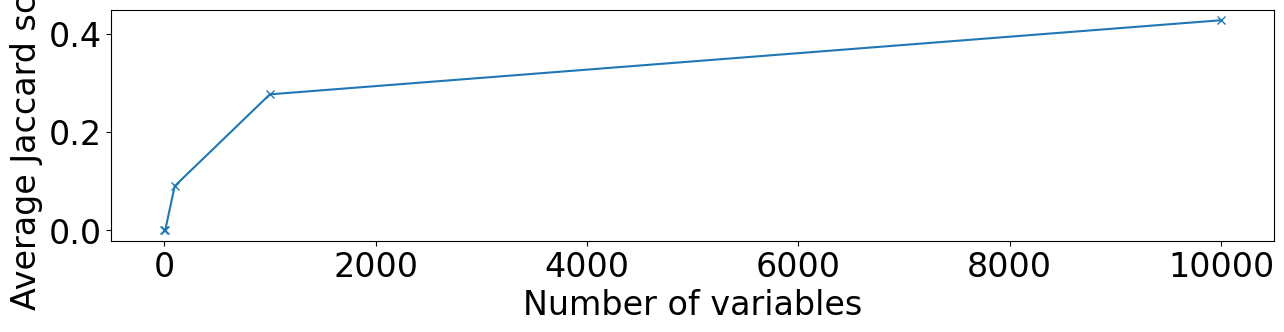

In [17]:
# Show the Jaccard scores
plt.figure(figsize=(15, 3))
plt.plot(n_args, avg_jaccard_scores, 'x-')
plt.xlabel("Number of variables")
plt.ylabel(f"Average Jaccard score")
plt.show()

In [18]:
order_IG = np.argsort(-scores_IG)
order_var = np.argsort(-scores_var)
order_PCA = np.argsort(-scores_PCA_PC1)
order_F = np.argsort(-scores_F)
order_MI = np.argsort(-scores_MI)
order_chi2 = np.argsort(-scores_chi2)
order_RFE = np.argsort(-scores_RFE)
order_L1 = np.argsort(-scores_L1)
order_Tree = np.argsort(-scores_Tree)

n_args = [1, 10, 100, 1000, 10000]
avg_jaccard_scores_var = []
avg_jaccard_scores_PCA = []
avg_jaccard_scores_F = []
avg_jaccard_scores_MI = []
avg_jaccard_scores_chi2 = []
avg_jaccard_scores_RFE = []
avg_jaccard_scores_L1 = []
avg_jaccard_scores_Tree = []

for n in n_args:
    set_IG = set(order_IG[:n])
    set_var = set(order_var[:n])
    set_PCA = set(order_PCA[:n])
    set_F = set(order_F[:n])
    set_MI = set(order_MI[:n])
    set_chi2 = set(order_chi2[:n])
    set_RFE = set(order_RFE[:n])
    set_L1 = set(order_L1[:n])
    set_Tree = set(order_Tree[:n])

    avg_jaccard_scores_var.append(len(list(set_IG.intersection(set_var))) / n)
    avg_jaccard_scores_PCA.append(len(list(set_IG.intersection(set_PCA))) / n)
    avg_jaccard_scores_F.append(len(list(set_IG.intersection(set_F))) / n)
    avg_jaccard_scores_MI.append(len(list(set_IG.intersection(set_MI))) / n)
    avg_jaccard_scores_chi2.append(len(list(set_IG.intersection(set_chi2))) / n)
    avg_jaccard_scores_RFE.append(len(list(set_IG.intersection(set_RFE))) / n)
    avg_jaccard_scores_L1.append(len(list(set_IG.intersection(set_L1))) / n)
    avg_jaccard_scores_Tree.append(len(list(set_IG.intersection(set_Tree))) / n)

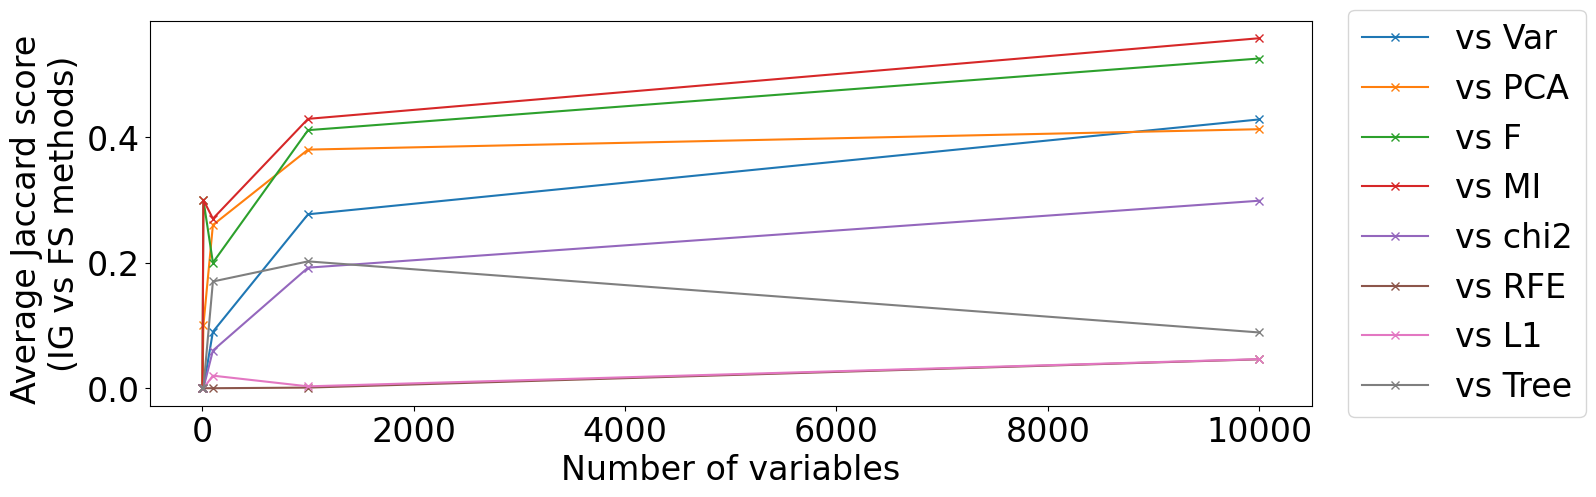

In [19]:
# Show the Jaccard scores
plt.figure(figsize=(15, 5))
plt.plot(n_args, avg_jaccard_scores_var, 'x-', label = "vs Var")
plt.plot(n_args, avg_jaccard_scores_PCA, 'x-', label = "vs PCA")
plt.plot(n_args, avg_jaccard_scores_F, 'x-', label = "vs F")
plt.plot(n_args, avg_jaccard_scores_MI, 'x-', label = "vs MI")
plt.plot(n_args, avg_jaccard_scores_chi2, 'x-', label = "vs chi2")
plt.plot(n_args, avg_jaccard_scores_RFE, 'x-', label = "vs RFE")
plt.plot(n_args, avg_jaccard_scores_L1, 'x-', label = "vs L1")
plt.plot(n_args, avg_jaccard_scores_Tree, 'x-', label = "vs Tree")
plt.xlabel("Number of variables")
plt.ylabel(f"Average Jaccard score \n(IG vs FS methods)")
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.show()

### Remark
It may be interesting to check the features bio-markers selected with each method on the simulation data in order to evaluate which method identifies the markers correctly.
We can implement it by:
1. Making a "ground truth" set consisting on the features with value =1 if true correlated markers, and =0 if uncorrelated markers
2. Computing the intersection as done previously but between the sorted method scores and the "ground truth"
3. Interprate and conclude: the higher the number the better the method to identify true markers !

I am sorry I could not code it yet as I did not manage to generate SIMU1 and SIMU2

### Barplots for visual representation of score (dis)similarity for each features

Text(0.5, 0, 'Score Tree')

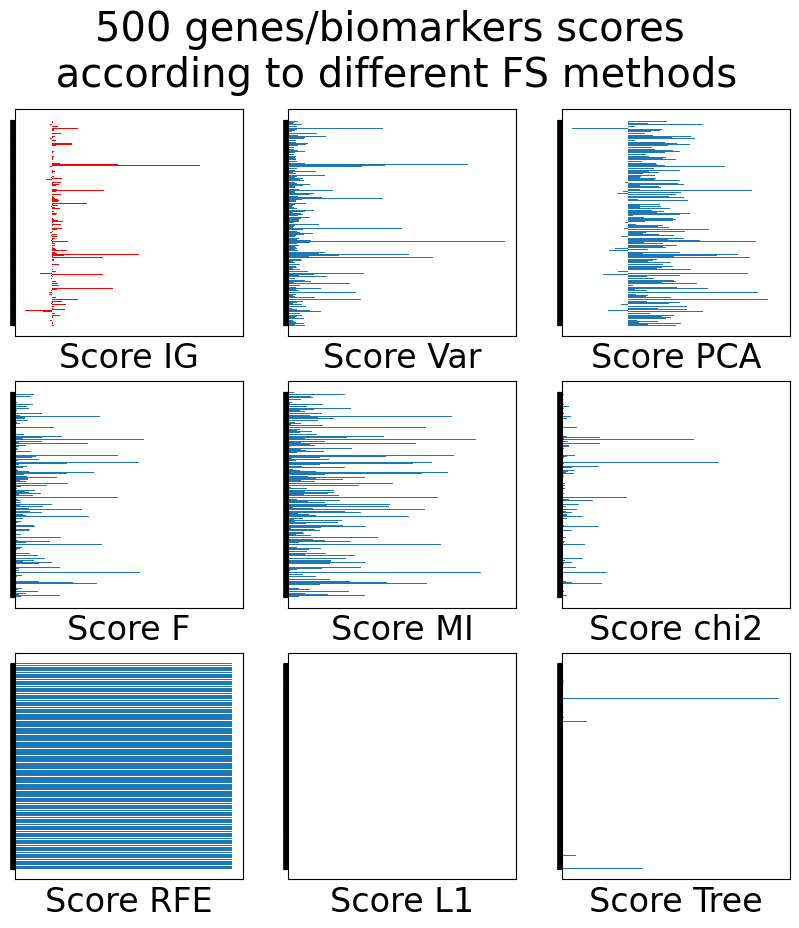

In [20]:
n = 500 # The number of first genes/features to observe

fig, ax = plt.subplots(3,3,  figsize=(10, 10))
fig.suptitle(f'{n} genes/biomarkers scores\n according to different FS methods')
# Our method + dimension reduction methods
ax[0, 0].barh(feat_name[:n], scores_IG[:n], align='center', color='red') # Colored in red to highlight our method
ax[0, 0].set_yticklabels([])
ax[0, 0].set_xticks([])
ax[0, 0].set_xlabel('Score IG')

ax[0, 1].barh(feat_name[:n], scores_var[:n], align='center')
ax[0, 1].set_yticklabels([])
ax[0, 1].set_xticks([])
ax[0, 1].set_xlabel('Score Var')

ax[0, 2].barh(feat_name[:n], scores_PCA_PC1[:n], align='center')
ax[0, 2].set_yticklabels([])
ax[0, 2].set_xticks([])
ax[0, 2].set_xlabel('Score PCA')

# Filter methods
ax[1, 0].barh(feat_name[:n], scores_F[:n], align='center')
ax[1, 0].set_yticklabels([])
ax[1, 0].set_xticks([])
ax[1, 0].set_xlabel('Score F')

ax[1, 1].barh(feat_name[:n], scores_MI[:n], align='center')
ax[1, 1].set_yticklabels([])
ax[1, 1].set_xticks([])
ax[1, 1].set_xlabel('Score MI')

ax[1, 2].barh(feat_name[:n], scores_chi2[:n], align='center')
ax[1, 2].set_yticklabels([])
ax[1, 2].set_xticks([])
ax[1, 2].set_xlabel('Score chi2')

# Wrapper/Embedded methods
ax[2, 0].barh(feat_name[:n], scores_RFE[:n], align='center')
ax[2, 0].set_yticklabels([])
ax[2, 0].set_xticks([])
ax[2, 0].set_xlabel('Score RFE')

ax[2, 1].barh(feat_name[:n], scores_L1[:n], align='center')
ax[2, 1].set_yticklabels([])
ax[2, 1].set_xticks([])
ax[2, 1].set_xlabel('Score L1')

ax[2, 2].barh(feat_name[:n], scores_Tree[:n], align='center')
ax[2, 2].set_yticklabels([])
ax[2, 2].set_xticks([])
ax[2, 2].set_xlabel('Score Tree')

Potential changes to make:
- Rescaling score for ease of comparision before making the barplot
- Maybe color the genes according to their function in the bar plot (is a pattern existing?)
- For simulation data SIMU1 and SIMU2, add a subplot with "ground truth" scores consisting on the features with value =1 if true correlated markers, and =0 if uncorrelated markers

To note Jaccard plot more interesting !